### Importing Necessary Libraries

In [130]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2S, Xception
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [131]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [132]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [133]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [134]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')

In [135]:
roi_info.shape

(16000, 100, 6)

## Data Preparation

Below we load the visual features for each document as generated in [EfficientNet kPiece Model](EfficientNet-kPiece-Model.ipynb). We will use this for fine-tuning.

### Training Data

In [136]:
fine_tune_data = np.load(f'./Data/EffNet-kP-train-precompute/whole_train_data_precomp_roi_n_4p.npy')

In [137]:
fine_tune_data.shape

(16000, 7680)

In [138]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [139]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 7680)

In [140]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [141]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 7680)

In [142]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

Now, we observe that the input vector for each image is $7680D$ which is pretty high dimensional. Since, it consistd of $6$ parts of $1280D$, on each part we use PCA to reduce the dimensions to a reasonable number.

In [143]:
N_COMPS = 512
pcas = [PCA(N_COMPS) for _ in range(6)]

In [144]:
for i in range(6):
    pcas[i].fit(fine_tune_data_train[:,(1280*i):(1280*(i+1))])

In [145]:
fine_tune_data_train_red = np.zeros((fine_tune_data_train.shape[0], 6 * N_COMPS))
for i in range(6):
    fine_tune_data_train_red[:,(N_COMPS*i):(N_COMPS*(i+1))] = pcas[i].transform(fine_tune_data_train[:,(1280*i):(1280*(i+1))])

In [146]:
fine_tune_data_train_red.shape

(15200, 3072)

In [147]:
fine_tune_data_test_red = np.zeros((fine_tune_data_test.shape[0], 6 * N_COMPS))
for i in range(6):
    fine_tune_data_test_red[:,(N_COMPS*i):(N_COMPS*(i+1))] = pcas[i].transform(fine_tune_data_test[:,(1280*i):(1280*(i+1))])

In [148]:
fine_tune_data_test_red.shape

(800, 3072)

### Validation Data

In [149]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [150]:
roi_info_validation = np.load('./Data/ROI-Extractions/validation/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [151]:
fine_tune_data_validation = np.load(f'./Data/EffNet-kP-validation-precompute/whole_validation_data_precomp_roi_n_4p.npy')

In [152]:
fine_tune_data_validation.shape

(900, 7680)

In [153]:
fine_tune_data_validation_red = np.zeros((fine_tune_data_validation.shape[0], 6 * N_COMPS))
for i in range(6):
    fine_tune_data_validation_red[:,(N_COMPS*i):(N_COMPS*(i+1))] = pcas[i].transform(fine_tune_data_validation[:,(1280*i):(1280*(i+1))])

In [154]:
fine_tune_data_validation_red.shape

(900, 3072)

## Fine-Tuning Models

The fine-tuning part of our model.

In [183]:
def ftmodel():
    inputs = Input(shape=(6*N_COMPS))
    x = BatchNormalization()(inputs)

    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='EfficientNet-FineTune')
    return model1

In [184]:
model1 = ftmodel()
model1.summary()

Model: "EfficientNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3072)]            0         
                                                                 
 batch_normalization_15 (Bat  (None, 3072)             12288     
 chNormalization)                                                
                                                                 
 top_dropout_2 (Dropout)     (None, 3072)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               1573376   
                                                                 
 batch_normalization_16 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 top_dropout_3 (Dropout)     (None, 512)     

### Model Training

The fine-tuning will be done on the EfficientNet's $1280D$ representation vectors for $5$ pieces of the image and the averaged ROI representation vectors.

In [157]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [158]:
EPOCHS = 2000
checkpoint_filepaths = ['./Models/EfficientNet-kP-PCA/auto-EffNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [159]:
history = model1.fit(fine_tune_data_train_red, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test_red, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
# history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/EfficientNet-kP-PCA/effnet-kp-model-weights")
model1.load_weights('./Models/EfficientNet-kP-PCA/effnet-kp-model-weights')

Epoch 1/2000
 1/19 [>.............................] - ETA: 7s - loss: 4.0174 - accuracy: 0.0550

2022-10-07 23:21:46.003681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 25ms/step - loss: 3.0747 - accuracy: 0.1985 - val_loss: 2.7352 - val_accuracy: 0.3525
Epoch 2/2000
 6/19 [========>.....................] - ETA: 0s - loss: 2.0729 - accuracy: 0.4271

2022-10-07 23:21:46.515805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 14ms/step - loss: 1.8688 - accuracy: 0.4798 - val_loss: 2.6559 - val_accuracy: 0.4338
Epoch 3/2000
19/19 [==============================] - 0s 14ms/step - loss: 1.4401 - accuracy: 0.5895 - val_loss: 2.5968 - val_accuracy: 0.4387
Epoch 4/2000
19/19 [==============================] - 0s 15ms/step - loss: 1.2132 - accuracy: 0.6593 - val_loss: 2.5416 - val_accuracy: 0.4312
Epoch 5/2000
19/19 [==============================] - 0s 14ms/step - loss: 1.0595 - accuracy: 0.7007 - val_loss: 2.4856 - val_accuracy: 0.4175
Epoch 6/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.9423 - accuracy: 0.7349 - val_loss: 2.4258 - val_accuracy: 0.4175
Epoch 7/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.8746 - accuracy: 0.7557 - val_loss: 2.3637 - val_accuracy: 0.4212
Epoch 8/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.7973 - accuracy: 0.7739 - val_loss: 2.2993 - val_accuracy: 0.4287
Epoch 9/2000

19/19 [==============================] - 0s 14ms/step - loss: 0.1130 - accuracy: 0.9880 - val_loss: 1.0289 - val_accuracy: 0.7337
Epoch 60/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.1103 - accuracy: 0.9887 - val_loss: 1.0369 - val_accuracy: 0.7325
Epoch 61/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.1092 - accuracy: 0.9891 - val_loss: 1.0345 - val_accuracy: 0.7375
Epoch 62/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.1097 - accuracy: 0.9898 - val_loss: 1.0363 - val_accuracy: 0.7362
Epoch 63/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.1061 - accuracy: 0.9893 - val_loss: 1.0341 - val_accuracy: 0.7412
Epoch 64/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.1061 - accuracy: 0.9893 - val_loss: 1.0364 - val_accuracy: 0.7387
Epoch 65/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.1022 - accuracy: 0.9901 - val_loss: 1.0367 - val_accuracy: 0.7425
Epoch 

Epoch 116/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0709 - accuracy: 0.9963 - val_loss: 1.0873 - val_accuracy: 0.7425
Epoch 117/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0692 - accuracy: 0.9965 - val_loss: 1.0865 - val_accuracy: 0.7425
Epoch 118/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0689 - accuracy: 0.9966 - val_loss: 1.0807 - val_accuracy: 0.7462
Epoch 119/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0676 - accuracy: 0.9972 - val_loss: 1.0835 - val_accuracy: 0.7550
Epoch 120/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.0674 - accuracy: 0.9972 - val_loss: 1.0844 - val_accuracy: 0.7500
Epoch 121/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0678 - accuracy: 0.9967 - val_loss: 1.0888 - val_accuracy: 0.7487
Epoch 122/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0681 - accuracy: 0.9965 - val_loss: 1.0840 - val_ac

19/19 [==============================] - 0s 10ms/step - loss: 0.0574 - accuracy: 0.9969 - val_loss: 1.1122 - val_accuracy: 0.7437
Epoch 173/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0564 - accuracy: 0.9976 - val_loss: 1.1065 - val_accuracy: 0.7437
Epoch 174/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0558 - accuracy: 0.9976 - val_loss: 1.1053 - val_accuracy: 0.7462
Epoch 175/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0556 - accuracy: 0.9981 - val_loss: 1.1066 - val_accuracy: 0.7437
Epoch 176/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0565 - accuracy: 0.9972 - val_loss: 1.0971 - val_accuracy: 0.7562
Epoch 177/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0562 - accuracy: 0.9974 - val_loss: 1.0905 - val_accuracy: 0.7525
Epoch 178/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0563 - accuracy: 0.9977 - val_loss: 1.0879 - val_accuracy: 0.7500


19/19 [==============================] - 0s 14ms/step - loss: 0.0494 - accuracy: 0.9979 - val_loss: 1.1324 - val_accuracy: 0.7550
Epoch 229/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0492 - accuracy: 0.9980 - val_loss: 1.1281 - val_accuracy: 0.7537
Epoch 230/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0488 - accuracy: 0.9984 - val_loss: 1.1407 - val_accuracy: 0.7512
Epoch 231/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0493 - accuracy: 0.9986 - val_loss: 1.1585 - val_accuracy: 0.7500
Epoch 232/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0491 - accuracy: 0.9980 - val_loss: 1.1538 - val_accuracy: 0.7525
Epoch 233/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0495 - accuracy: 0.9976 - val_loss: 1.1464 - val_accuracy: 0.7500
Epoch 234/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0492 - accuracy: 0.9978 - val_loss: 1.1580 - val_accuracy: 0.7512


19/19 [==============================] - 0s 11ms/step - loss: 0.0462 - accuracy: 0.9982 - val_loss: 1.1722 - val_accuracy: 0.7450
Epoch 285/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.0458 - accuracy: 0.9983 - val_loss: 1.1695 - val_accuracy: 0.7437
Epoch 286/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0469 - accuracy: 0.9980 - val_loss: 1.1600 - val_accuracy: 0.7512
Epoch 287/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0455 - accuracy: 0.9982 - val_loss: 1.1632 - val_accuracy: 0.7612
Epoch 288/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0462 - accuracy: 0.9984 - val_loss: 1.1563 - val_accuracy: 0.7575
Epoch 289/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0456 - accuracy: 0.9983 - val_loss: 1.1490 - val_accuracy: 0.7500
Epoch 290/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0459 - accuracy: 0.9982 - val_loss: 1.1478 - val_accuracy: 0.7512


19/19 [==============================] - 0s 14ms/step - loss: 0.0442 - accuracy: 0.9986 - val_loss: 1.1556 - val_accuracy: 0.7400
Epoch 341/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0444 - accuracy: 0.9982 - val_loss: 1.1506 - val_accuracy: 0.7462
Epoch 342/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0457 - accuracy: 0.9980 - val_loss: 1.1455 - val_accuracy: 0.7437
Epoch 343/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.0435 - accuracy: 0.9986 - val_loss: 1.1500 - val_accuracy: 0.7437
Epoch 344/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0428 - accuracy: 0.9989 - val_loss: 1.1594 - val_accuracy: 0.7450
Epoch 345/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0444 - accuracy: 0.9984 - val_loss: 1.1547 - val_accuracy: 0.7450
Epoch 346/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0432 - accuracy: 0.9982 - val_loss: 1.1486 - val_accuracy: 0.7487


19/19 [==============================] - 0s 10ms/step - loss: 0.0413 - accuracy: 0.9984 - val_loss: 1.1527 - val_accuracy: 0.7512
Epoch 397/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0432 - accuracy: 0.9978 - val_loss: 1.1551 - val_accuracy: 0.7525
Epoch 398/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0425 - accuracy: 0.9984 - val_loss: 1.1442 - val_accuracy: 0.7512
Epoch 399/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0434 - accuracy: 0.9980 - val_loss: 1.1501 - val_accuracy: 0.7487
Epoch 400/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0420 - accuracy: 0.9985 - val_loss: 1.1502 - val_accuracy: 0.7525
Epoch 401/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0425 - accuracy: 0.9982 - val_loss: 1.1459 - val_accuracy: 0.7512
Epoch 402/2000
19/19 [==============================] - 0s 15ms/step - loss: 0.0411 - accuracy: 0.9986 - val_loss: 1.1469 - val_accuracy: 0.7500


19/19 [==============================] - 0s 11ms/step - loss: 0.0423 - accuracy: 0.9982 - val_loss: 1.2268 - val_accuracy: 0.7475
Epoch 453/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0432 - accuracy: 0.9973 - val_loss: 1.2307 - val_accuracy: 0.7450
Epoch 454/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0428 - accuracy: 0.9983 - val_loss: 1.2215 - val_accuracy: 0.7537
Epoch 455/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0426 - accuracy: 0.9980 - val_loss: 1.2135 - val_accuracy: 0.7425
Epoch 456/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0421 - accuracy: 0.9978 - val_loss: 1.2038 - val_accuracy: 0.7462
Epoch 457/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0411 - accuracy: 0.9986 - val_loss: 1.2093 - val_accuracy: 0.7437
Epoch 458/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0421 - accuracy: 0.9981 - val_loss: 1.2101 - val_accuracy: 0.7475


19/19 [==============================] - 0s 11ms/step - loss: 0.0421 - accuracy: 0.9984 - val_loss: 1.2200 - val_accuracy: 0.7337
Epoch 509/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0405 - accuracy: 0.9987 - val_loss: 1.2251 - val_accuracy: 0.7437
Epoch 510/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0419 - accuracy: 0.9981 - val_loss: 1.2271 - val_accuracy: 0.7437
Epoch 511/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0403 - accuracy: 0.9985 - val_loss: 1.2351 - val_accuracy: 0.7412
Epoch 512/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0419 - accuracy: 0.9983 - val_loss: 1.2323 - val_accuracy: 0.7425
Epoch 513/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0412 - accuracy: 0.9978 - val_loss: 1.2213 - val_accuracy: 0.7425
Epoch 514/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0411 - accuracy: 0.9982 - val_loss: 1.2123 - val_accuracy: 0.7425


19/19 [==============================] - 0s 11ms/step - loss: 0.0411 - accuracy: 0.9982 - val_loss: 1.1720 - val_accuracy: 0.7562
Epoch 565/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0406 - accuracy: 0.9986 - val_loss: 1.1697 - val_accuracy: 0.7537
Epoch 566/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0403 - accuracy: 0.9982 - val_loss: 1.1795 - val_accuracy: 0.7512
Epoch 567/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0401 - accuracy: 0.9989 - val_loss: 1.1977 - val_accuracy: 0.7500
Epoch 568/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0404 - accuracy: 0.9985 - val_loss: 1.2065 - val_accuracy: 0.7450
Epoch 569/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0409 - accuracy: 0.9984 - val_loss: 1.2101 - val_accuracy: 0.7450
Epoch 570/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0394 - accuracy: 0.9986 - val_loss: 1.2121 - val_accuracy: 0.7425


19/19 [==============================] - 0s 10ms/step - loss: 0.0396 - accuracy: 0.9988 - val_loss: 1.1939 - val_accuracy: 0.7525
Epoch 621/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0416 - accuracy: 0.9978 - val_loss: 1.1907 - val_accuracy: 0.7500
Epoch 622/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0409 - accuracy: 0.9984 - val_loss: 1.1906 - val_accuracy: 0.7487
Epoch 623/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0399 - accuracy: 0.9987 - val_loss: 1.1895 - val_accuracy: 0.7475
Epoch 624/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0410 - accuracy: 0.9982 - val_loss: 1.1815 - val_accuracy: 0.7537
Epoch 625/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0408 - accuracy: 0.9985 - val_loss: 1.1857 - val_accuracy: 0.7462
Epoch 626/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0424 - accuracy: 0.9978 - val_loss: 1.1946 - val_accuracy: 0.7387


19/19 [==============================] - 0s 11ms/step - loss: 0.0406 - accuracy: 0.9984 - val_loss: 1.1812 - val_accuracy: 0.7512
Epoch 677/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0401 - accuracy: 0.9984 - val_loss: 1.1717 - val_accuracy: 0.7500
Epoch 678/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0400 - accuracy: 0.9986 - val_loss: 1.1565 - val_accuracy: 0.7537
Epoch 679/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0399 - accuracy: 0.9984 - val_loss: 1.1619 - val_accuracy: 0.7562
Epoch 680/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0398 - accuracy: 0.9983 - val_loss: 1.1687 - val_accuracy: 0.7500
Epoch 681/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0388 - accuracy: 0.9988 - val_loss: 1.1806 - val_accuracy: 0.7487
Epoch 682/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0393 - accuracy: 0.9984 - val_loss: 1.1696 - val_accuracy: 0.7525


19/19 [==============================] - 0s 10ms/step - loss: 0.0386 - accuracy: 0.9984 - val_loss: 1.1199 - val_accuracy: 0.7500
Epoch 733/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0380 - accuracy: 0.9989 - val_loss: 1.1296 - val_accuracy: 0.7537
Epoch 734/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0384 - accuracy: 0.9986 - val_loss: 1.1366 - val_accuracy: 0.7537
Epoch 735/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0392 - accuracy: 0.9983 - val_loss: 1.1450 - val_accuracy: 0.7475
Epoch 736/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0383 - accuracy: 0.9986 - val_loss: 1.1556 - val_accuracy: 0.7550
Epoch 737/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0385 - accuracy: 0.9982 - val_loss: 1.1552 - val_accuracy: 0.7537
Epoch 738/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0382 - accuracy: 0.9989 - val_loss: 1.1662 - val_accuracy: 0.7475


19/19 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9989 - val_loss: 1.1374 - val_accuracy: 0.7637
Epoch 789/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0400 - accuracy: 0.9980 - val_loss: 1.1253 - val_accuracy: 0.7713
Epoch 790/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0392 - accuracy: 0.9981 - val_loss: 1.1316 - val_accuracy: 0.7662
Epoch 791/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0391 - accuracy: 0.9983 - val_loss: 1.1346 - val_accuracy: 0.7625
Epoch 792/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0393 - accuracy: 0.9986 - val_loss: 1.1437 - val_accuracy: 0.7662
Epoch 793/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0388 - accuracy: 0.9988 - val_loss: 1.1546 - val_accuracy: 0.7662
Epoch 794/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0395 - accuracy: 0.9980 - val_loss: 1.1547 - val_accuracy: 0.7612


19/19 [==============================] - 0s 10ms/step - loss: 0.0391 - accuracy: 0.9983 - val_loss: 1.2012 - val_accuracy: 0.7675
Epoch 845/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0414 - accuracy: 0.9975 - val_loss: 1.2036 - val_accuracy: 0.7575
Epoch 846/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0395 - accuracy: 0.9985 - val_loss: 1.1995 - val_accuracy: 0.7562
Epoch 847/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0399 - accuracy: 0.9983 - val_loss: 1.1947 - val_accuracy: 0.7600
Epoch 848/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0397 - accuracy: 0.9986 - val_loss: 1.1860 - val_accuracy: 0.7600
Epoch 849/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0394 - accuracy: 0.9983 - val_loss: 1.1813 - val_accuracy: 0.7675
Epoch 850/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9991 - val_loss: 1.1855 - val_accuracy: 0.7725


19/19 [==============================] - 0s 10ms/step - loss: 0.0403 - accuracy: 0.9986 - val_loss: 1.1533 - val_accuracy: 0.7775
Epoch 901/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0384 - accuracy: 0.9988 - val_loss: 1.1714 - val_accuracy: 0.7700
Epoch 902/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0379 - accuracy: 0.9989 - val_loss: 1.1710 - val_accuracy: 0.7662
Epoch 903/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0398 - accuracy: 0.9978 - val_loss: 1.1485 - val_accuracy: 0.7700
Epoch 904/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9985 - val_loss: 1.1500 - val_accuracy: 0.7688
Epoch 905/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0386 - accuracy: 0.9984 - val_loss: 1.1468 - val_accuracy: 0.7662
Epoch 906/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9988 - val_loss: 1.1407 - val_accuracy: 0.7725


19/19 [==============================] - 0s 11ms/step - loss: 0.0381 - accuracy: 0.9987 - val_loss: 1.2446 - val_accuracy: 0.7425
Epoch 957/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0392 - accuracy: 0.9986 - val_loss: 1.2408 - val_accuracy: 0.7462
Epoch 958/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0391 - accuracy: 0.9982 - val_loss: 1.2334 - val_accuracy: 0.7337
Epoch 959/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0385 - accuracy: 0.9986 - val_loss: 1.2151 - val_accuracy: 0.7375
Epoch 960/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0388 - accuracy: 0.9984 - val_loss: 1.2192 - val_accuracy: 0.7412
Epoch 961/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0395 - accuracy: 0.9982 - val_loss: 1.2359 - val_accuracy: 0.7387
Epoch 962/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9989 - val_loss: 1.2400 - val_accuracy: 0.7362


19/19 [==============================] - 0s 10ms/step - loss: 0.0377 - accuracy: 0.9986 - val_loss: 1.2171 - val_accuracy: 0.7575
Epoch 1013/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0378 - accuracy: 0.9987 - val_loss: 1.2203 - val_accuracy: 0.7575
Epoch 1014/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0376 - accuracy: 0.9993 - val_loss: 1.2232 - val_accuracy: 0.7500
Epoch 1015/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9987 - val_loss: 1.2208 - val_accuracy: 0.7450
Epoch 1016/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0385 - accuracy: 0.9981 - val_loss: 1.2231 - val_accuracy: 0.7475
Epoch 1017/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9984 - val_loss: 1.2323 - val_accuracy: 0.7487
Epoch 1018/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0367 - accuracy: 0.9987 - val_loss: 1.2393 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0384 - accuracy: 0.9983 - val_loss: 1.2241 - val_accuracy: 0.7587
Epoch 1069/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0388 - accuracy: 0.9979 - val_loss: 1.2258 - val_accuracy: 0.7625
Epoch 1070/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9988 - val_loss: 1.2365 - val_accuracy: 0.7612
Epoch 1071/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9987 - val_loss: 1.2336 - val_accuracy: 0.7600
Epoch 1072/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0398 - accuracy: 0.9986 - val_loss: 1.2335 - val_accuracy: 0.7587
Epoch 1073/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9986 - val_loss: 1.2433 - val_accuracy: 0.7600
Epoch 1074/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0393 - accuracy: 0.9985 - val_loss: 1.2377 - val_accuracy: 0

19/19 [==============================] - 0s 11ms/step - loss: 0.0390 - accuracy: 0.9981 - val_loss: 1.2366 - val_accuracy: 0.7550
Epoch 1125/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0379 - accuracy: 0.9989 - val_loss: 1.2521 - val_accuracy: 0.7550
Epoch 1126/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9989 - val_loss: 1.2461 - val_accuracy: 0.7525
Epoch 1127/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0383 - accuracy: 0.9988 - val_loss: 1.2312 - val_accuracy: 0.7562
Epoch 1128/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9989 - val_loss: 1.2176 - val_accuracy: 0.7537
Epoch 1129/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9989 - val_loss: 1.2098 - val_accuracy: 0.7587
Epoch 1130/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0380 - accuracy: 0.9989 - val_loss: 1.2020 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9982 - val_loss: 1.2326 - val_accuracy: 0.7562
Epoch 1181/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9989 - val_loss: 1.2269 - val_accuracy: 0.7625
Epoch 1182/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0363 - accuracy: 0.9991 - val_loss: 1.2270 - val_accuracy: 0.7575
Epoch 1183/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0364 - accuracy: 0.9991 - val_loss: 1.2367 - val_accuracy: 0.7575
Epoch 1184/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0360 - accuracy: 0.9993 - val_loss: 1.2519 - val_accuracy: 0.7550
Epoch 1185/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9984 - val_loss: 1.2486 - val_accuracy: 0.7575
Epoch 1186/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0377 - accuracy: 0.9985 - val_loss: 1.2509 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0368 - accuracy: 0.9988 - val_loss: 1.1939 - val_accuracy: 0.7550
Epoch 1237/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0377 - accuracy: 0.9987 - val_loss: 1.1975 - val_accuracy: 0.7575
Epoch 1238/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0371 - accuracy: 0.9988 - val_loss: 1.2039 - val_accuracy: 0.7525
Epoch 1239/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9982 - val_loss: 1.2104 - val_accuracy: 0.7512
Epoch 1240/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0372 - accuracy: 0.9987 - val_loss: 1.2085 - val_accuracy: 0.7525
Epoch 1241/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0373 - accuracy: 0.9986 - val_loss: 1.2206 - val_accuracy: 0.7525
Epoch 1242/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0369 - accuracy: 0.9988 - val_loss: 1.2241 - val_accuracy: 0

19/19 [==============================] - 0s 11ms/step - loss: 0.0376 - accuracy: 0.9982 - val_loss: 1.2449 - val_accuracy: 0.7550
Epoch 1293/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0371 - accuracy: 0.9985 - val_loss: 1.2367 - val_accuracy: 0.7587
Epoch 1294/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0371 - accuracy: 0.9989 - val_loss: 1.2329 - val_accuracy: 0.7525
Epoch 1295/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.0371 - accuracy: 0.9986 - val_loss: 1.2404 - val_accuracy: 0.7525
Epoch 1296/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0363 - accuracy: 0.9991 - val_loss: 1.2446 - val_accuracy: 0.7550
Epoch 1297/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0381 - accuracy: 0.9982 - val_loss: 1.2541 - val_accuracy: 0.7550
Epoch 1298/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0377 - accuracy: 0.9986 - val_loss: 1.2499 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0386 - accuracy: 0.9982 - val_loss: 1.2840 - val_accuracy: 0.7475
Epoch 1349/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0380 - accuracy: 0.9982 - val_loss: 1.2751 - val_accuracy: 0.7500
Epoch 1350/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0368 - accuracy: 0.9988 - val_loss: 1.2689 - val_accuracy: 0.7487
Epoch 1351/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0368 - accuracy: 0.9988 - val_loss: 1.2694 - val_accuracy: 0.7550
Epoch 1352/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0377 - accuracy: 0.9984 - val_loss: 1.2761 - val_accuracy: 0.7600
Epoch 1353/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0380 - accuracy: 0.9988 - val_loss: 1.2697 - val_accuracy: 0.7600
Epoch 1354/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0371 - accuracy: 0.9989 - val_loss: 1.2752 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0376 - accuracy: 0.9984 - val_loss: 1.2583 - val_accuracy: 0.7525
Epoch 1405/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0376 - accuracy: 0.9985 - val_loss: 1.2278 - val_accuracy: 0.7625
Epoch 1406/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0383 - accuracy: 0.9985 - val_loss: 1.2208 - val_accuracy: 0.7637
Epoch 1407/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0379 - accuracy: 0.9984 - val_loss: 1.2147 - val_accuracy: 0.7575
Epoch 1408/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9983 - val_loss: 1.2189 - val_accuracy: 0.7587
Epoch 1409/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0369 - accuracy: 0.9990 - val_loss: 1.2099 - val_accuracy: 0.7612
Epoch 1410/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9983 - val_loss: 1.2158 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0392 - accuracy: 0.9982 - val_loss: 1.2097 - val_accuracy: 0.7562
Epoch 1461/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0384 - accuracy: 0.9986 - val_loss: 1.2140 - val_accuracy: 0.7525
Epoch 1462/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0371 - accuracy: 0.9989 - val_loss: 1.2150 - val_accuracy: 0.7562
Epoch 1463/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0385 - accuracy: 0.9983 - val_loss: 1.2229 - val_accuracy: 0.7475
Epoch 1464/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0378 - accuracy: 0.9985 - val_loss: 1.2306 - val_accuracy: 0.7425
Epoch 1465/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9983 - val_loss: 1.2403 - val_accuracy: 0.7525
Epoch 1466/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0370 - accuracy: 0.9989 - val_loss: 1.2348 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0373 - accuracy: 0.9986 - val_loss: 1.2352 - val_accuracy: 0.7362
Epoch 1517/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0368 - accuracy: 0.9989 - val_loss: 1.2377 - val_accuracy: 0.7387
Epoch 1518/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0372 - accuracy: 0.9986 - val_loss: 1.2472 - val_accuracy: 0.7450
Epoch 1519/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0373 - accuracy: 0.9986 - val_loss: 1.2682 - val_accuracy: 0.7450
Epoch 1520/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0366 - accuracy: 0.9988 - val_loss: 1.2706 - val_accuracy: 0.7462
Epoch 1521/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0358 - accuracy: 0.9994 - val_loss: 1.2742 - val_accuracy: 0.7487
Epoch 1522/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0376 - accuracy: 0.9984 - val_loss: 1.2850 - val_accuracy: 0

19/19 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9982 - val_loss: 1.2338 - val_accuracy: 0.7587
Epoch 1573/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0367 - accuracy: 0.9989 - val_loss: 1.2425 - val_accuracy: 0.7587
Epoch 1574/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0384 - accuracy: 0.9987 - val_loss: 1.2445 - val_accuracy: 0.7500
Epoch 1575/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0380 - accuracy: 0.9984 - val_loss: 1.2351 - val_accuracy: 0.7537
Epoch 1576/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0383 - accuracy: 0.9983 - val_loss: 1.2280 - val_accuracy: 0.7537
Epoch 1577/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0381 - accuracy: 0.9986 - val_loss: 1.2162 - val_accuracy: 0.7487
Epoch 1578/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0388 - accuracy: 0.9986 - val_loss: 1.2243 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9986 - val_loss: 1.2463 - val_accuracy: 0.7500
Epoch 1629/2000
19/19 [==============================] - 0s 12ms/step - loss: 0.0373 - accuracy: 0.9986 - val_loss: 1.2480 - val_accuracy: 0.7525
Epoch 1630/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0386 - accuracy: 0.9981 - val_loss: 1.2380 - val_accuracy: 0.7550
Epoch 1631/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9982 - val_loss: 1.2335 - val_accuracy: 0.7587
Epoch 1632/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0377 - accuracy: 0.9986 - val_loss: 1.2460 - val_accuracy: 0.7512
Epoch 1633/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9991 - val_loss: 1.2535 - val_accuracy: 0.7512
Epoch 1634/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0378 - accuracy: 0.9985 - val_loss: 1.2403 - val_accuracy: 0

19/19 [==============================] - 0s 11ms/step - loss: 0.0364 - accuracy: 0.9988 - val_loss: 1.2950 - val_accuracy: 0.7412
Epoch 1685/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0361 - accuracy: 0.9990 - val_loss: 1.2901 - val_accuracy: 0.7412
Epoch 1686/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0374 - accuracy: 0.9986 - val_loss: 1.2702 - val_accuracy: 0.7425
Epoch 1687/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0359 - accuracy: 0.9989 - val_loss: 1.2664 - val_accuracy: 0.7437
Epoch 1688/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0367 - accuracy: 0.9988 - val_loss: 1.2771 - val_accuracy: 0.7412
Epoch 1689/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0366 - accuracy: 0.9990 - val_loss: 1.2741 - val_accuracy: 0.7437
Epoch 1690/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0376 - accuracy: 0.9982 - val_loss: 1.2671 - val_accuracy: 0

19/19 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9991 - val_loss: 1.2444 - val_accuracy: 0.7512
Epoch 1741/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0370 - accuracy: 0.9988 - val_loss: 1.2431 - val_accuracy: 0.7500
Epoch 1742/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0371 - accuracy: 0.9988 - val_loss: 1.2359 - val_accuracy: 0.7487
Epoch 1743/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9990 - val_loss: 1.2345 - val_accuracy: 0.7500
Epoch 1744/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0389 - accuracy: 0.9981 - val_loss: 1.2398 - val_accuracy: 0.7487
Epoch 1745/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0366 - accuracy: 0.9991 - val_loss: 1.2392 - val_accuracy: 0.7512
Epoch 1746/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0370 - accuracy: 0.9988 - val_loss: 1.2349 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0370 - accuracy: 0.9988 - val_loss: 1.2396 - val_accuracy: 0.7550
Epoch 1797/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0361 - accuracy: 0.9993 - val_loss: 1.2434 - val_accuracy: 0.7575
Epoch 1798/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0368 - accuracy: 0.9987 - val_loss: 1.2439 - val_accuracy: 0.7575
Epoch 1799/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0370 - accuracy: 0.9991 - val_loss: 1.2443 - val_accuracy: 0.7550
Epoch 1800/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9985 - val_loss: 1.2382 - val_accuracy: 0.7525
Epoch 1801/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0367 - accuracy: 0.9986 - val_loss: 1.2428 - val_accuracy: 0.7537
Epoch 1802/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0367 - accuracy: 0.9990 - val_loss: 1.2388 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0364 - accuracy: 0.9989 - val_loss: 1.2270 - val_accuracy: 0.7525
Epoch 1853/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0364 - accuracy: 0.9986 - val_loss: 1.2272 - val_accuracy: 0.7525
Epoch 1854/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0368 - accuracy: 0.9989 - val_loss: 1.2389 - val_accuracy: 0.7525
Epoch 1855/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0361 - accuracy: 0.9989 - val_loss: 1.2413 - val_accuracy: 0.7487
Epoch 1856/2000
19/19 [==============================] - 0s 14ms/step - loss: 0.0355 - accuracy: 0.9992 - val_loss: 1.2392 - val_accuracy: 0.7475
Epoch 1857/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0372 - accuracy: 0.9986 - val_loss: 1.2373 - val_accuracy: 0.7500
Epoch 1858/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0371 - accuracy: 0.9987 - val_loss: 1.2310 - val_accuracy: 0

19/19 [==============================] - 0s 11ms/step - loss: 0.0374 - accuracy: 0.9984 - val_loss: 1.1920 - val_accuracy: 0.7562
Epoch 1909/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0374 - accuracy: 0.9986 - val_loss: 1.1935 - val_accuracy: 0.7575
Epoch 1910/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0363 - accuracy: 0.9987 - val_loss: 1.1956 - val_accuracy: 0.7600
Epoch 1911/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9982 - val_loss: 1.1847 - val_accuracy: 0.7537
Epoch 1912/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9990 - val_loss: 1.1795 - val_accuracy: 0.7525
Epoch 1913/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0371 - accuracy: 0.9986 - val_loss: 1.1708 - val_accuracy: 0.7587
Epoch 1914/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0357 - accuracy: 0.9992 - val_loss: 1.1719 - val_accuracy: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.0369 - accuracy: 0.9989 - val_loss: 1.1604 - val_accuracy: 0.7512
Epoch 1965/2000
19/19 [==============================] - 0s 10ms/step - loss: 0.0369 - accuracy: 0.9988 - val_loss: 1.1629 - val_accuracy: 0.7512
Epoch 1966/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0372 - accuracy: 0.9989 - val_loss: 1.1647 - val_accuracy: 0.7500
Epoch 1967/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0374 - accuracy: 0.9986 - val_loss: 1.1810 - val_accuracy: 0.7575
Epoch 1968/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0369 - accuracy: 0.9991 - val_loss: 1.1897 - val_accuracy: 0.7575
Epoch 1969/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0372 - accuracy: 0.9987 - val_loss: 1.1917 - val_accuracy: 0.7587
Epoch 1970/2000
19/19 [==============================] - 0s 11ms/step - loss: 0.0366 - accuracy: 0.9989 - val_loss: 1.1880 - val_accuracy: 0

In [160]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

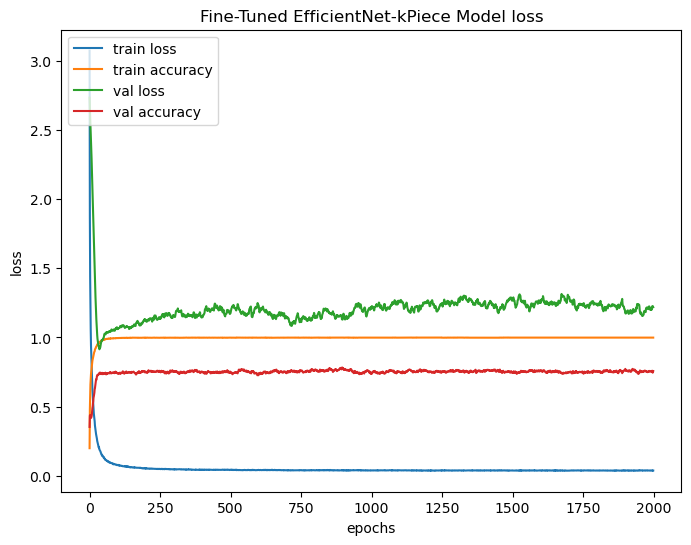

In [161]:
plot_train_loss(history, 'Fine-Tuned EfficientNet-kPiece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [162]:
train_preds = model1.predict(fine_tune_data_train_red)

 69/475 [===>..........................] - ETA: 0s

2022-10-07 23:28:44.029002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 2ms/step


In [163]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [164]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [165]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [166]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [167]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [168]:
test_preds = model1.predict(fine_tune_data_test_red)

25/25 [==============================] - 0s 3ms/step


In [169]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [170]:
test_pred_labels

array([11,  8,  6,  7,  1,  9, 13,  9, 14,  1,  6,  0,  7, 14,  1, 11,  0,
        9,  6, 12, 12, 14,  3,  9,  6,  0,  3,  0,  3,  3, 11,  1,  9,  2,
        1,  8,  6,  7,  1,  9,  6, 12, 14,  8,  5, 14,  3, 11, 13,  4,  0,
       10, 12,  0, 11, 14, 15,  6,  9,  2, 15,  9,  2, 11,  4, 10,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  5,  4, 12,  9,
        8,  5, 13, 13, 13, 10, 11,  4, 10,  1, 10, 11,  8, 13, 10,  9, 11,
       12,  9,  1, 14,  8,  2,  5, 10,  7, 10,  9,  4, 12, 14, 12,  1, 10,
        6,  8,  1,  0, 12,  1,  7, 10, 12, 15,  8,  3, 11,  6,  5,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8, 10,  8,  4,  2, 13,  0,  0,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 10, 13,  8,  2,  8,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11,  0, 11,  6, 13,  4,
       14,  1,  7, 15,  0,  3,  0, 10, 13, 13, 10,  1, 11,  7,  1,  9,  1,
        9,  5, 13, 15, 12,  1,  9,  8,  7,  9, 13, 12,  4, 12,  8,  0,  9,
       13, 15,  5,  0, 10

In [171]:
np.sum(test_pred_labels == test_labels['label'])

605

In [172]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
11,164,./Data/train/train/164.tif,15
19,372,./Data/train/train/372.tif,13
...,...,...,...
773,15508,./Data/train/train/15508.tif,10
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12


In [173]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.650794,0.759259,0.700855,54
1,0.529412,0.613636,0.568421,44
2,0.911111,0.953488,0.931818,43
3,0.933333,0.913043,0.923077,46
4,0.810811,0.833333,0.821918,36
5,0.641026,0.500000,0.561798,50
6,0.878049,0.782609,0.827586,46
7,0.784314,0.769231,0.776699,52
8,0.787879,0.962963,0.866667,54
9,0.787234,0.787234,0.787234,47


In [174]:
np.mean(fscore)

0.7564612780924312

#### On Validation Data

Generating Predictions for the Validation Set

In [175]:
valid_preds = model1.predict(fine_tune_data_validation_red)

29/29 [==============================] - 0s 3ms/step


2022-10-07 23:28:45.355855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [176]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

In [177]:
valid_pred_labels

array([11,  6,  4,  8,  3,  8,  1,  1,  2,  4,  3,  0, 12, 12, 13,  9,  1,
        1, 11, 12, 14,  9, 13,  6,  1,  2,  7,  3,  8,  1,  0, 14,  8, 10,
       14,  6, 11,  8,  6, 10,  4, 14, 12,  3,  2, 10,  3,  2,  4,  2, 10,
        0, 10,  0,  1,  9,  2,  8, 13,  1,  2, 11,  4,  5,  5,  8, 11,  7,
        8,  4,  5,  5,  4,  8,  4,  6,  4, 15, 11,  0,  9, 15,  5, 11,  7,
       15, 11, 10,  0, 10, 12,  5, 15, 15,  3,  4, 11, 10,  6,  5,  6, 11,
        1, 12,  7,  1, 15,  9, 10,  1,  7,  7,  7, 14,  2,  4,  1, 14, 12,
        1, 13,  1,  3,  6,  1, 10,  0,  6,  4, 12,  8,  1, 13,  8, 10,  3,
       11, 11,  5,  5,  6,  6,  2,  3,  2,  9,  9,  0,  0, 14, 10, 10,  1,
       11,  7,  3, 14,  1,  1, 14,  3, 11,  2, 13,  7, 14,  4,  5,  7,  9,
       12, 10,  4,  7,  4,  0,  1,  6, 11,  8, 15, 11,  3,  2,  3,  3, 14,
        3, 11,  2,  9,  5,  6,  2,  4,  9,  2,  9, 10,  7,  1, 13,  1,  0,
       15,  1,  4,  1,  4,  4,  8,  6,  6,  7,  4,  4, 13,  3, 10, 12,  1,
        6,  0,  8, 10,  2

### Submission

For Kaggle Submission

In [180]:
roi_info_validation[0]

array([[  6.31446934, 953.5032959 , 124.96561432, 983.04998779,
          1.        ,   1.        ],
       [  6.83573103, 967.67987061, 231.95384216, 982.98071289,
          1.        ,   1.        ],
       [ 21.61216927, 904.17651367, 725.11962891, 909.07617188,
          5.        ,   1.        ],
       [ 35.6613121 ,  15.60731411,  43.65130234,  22.02859116,
          1.        ,   1.        ],
       [ 78.91178131,  29.19843483, 692.08996582, 202.60029602,
          6.        ,   1.        ],
       [110.42622375, 127.7110672 , 637.99682617, 773.59735107,
          2.        ,   1.        ],
       [165.22764587, 847.66424561, 662.84649658, 854.0112915 ,
          5.        ,   1.        ],
       [532.09185791, 859.65454102, 639.74468994, 874.27435303,
          1.        ,   1.        ],
       [712.800354  ,   4.76252604, 715.38275146,  71.32498932,
          1.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0. 

In [178]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,11
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,3


In [179]:
submission_data.to_csv('./Submissions/submission-effnet-kPiece-PCA.csv', index=False)